# Recursive Green Function code - basic usage

In [2]:
from multiprocessing import Pool
import RGF_src as rgf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class bastin_integrator():
    # Simple adaptive integrator
    
    energies1 = -1
    energies = -1
    bastingrand = -1
    bastin = -1
    quiet = False
    
    de = -1 # must be set
    
    def __init__(self, fun, operator):
        # self.recursive = obj # Object of the rgf class
        self.fun = fun # function to be evaluated to integrate
        self.op = operator*1.0 
        
        
    def calc_stuff(self, z):
        b1 = self.fun(z, self.op, self.de)[0]
        if not self.quiet:
            print(f"{np.real(z[0]):5.5f}",end=" ")
        return b1
    
    def set_integrator(self, energies1, energies, de):
        self.energies1 = energies1*1.0 # integrand
        self.energies  = energies*1.0 # list of fermi energies
        self.de = de
        self.prev = energies*1j*0

In [3]:
def integrator(self, tol, eta1min, eta1max):

    NE1 = len(self.energies1)
    # tol = 0.1
    # tol = 0.01

    eta1 = eta1max
    do = True
    # while do:
    while eta1 > eta1min:
        do = False
        # Update eta

        # Comment this block if you just want to redo the algorithm for the last eta
        eta1 /= 3

        # Calculate the integrand parallelized
        zs1 = self.energies1 + eta1*1j
        bast = []
        with Pool(8) as p:
            bast = p.map(self.calc_stuff, list(np.array([z]) for z in zs1))
        self.bastingrand = np.array(bast)

        if not self.quiet:
            print("###################### ETA ",eta1,"###############################")
        else:
            print("eta", eta1)




        # Calculate the integral
        self.bastin = np.zeros(NE, dtype=complex)
        for i,mu in enumerate(self.energies):
            self.bastin[i] = rgf.cond(mu, self.energies1, self.bastingrand)

        # Refine the integrand
        while True:

            # Identify the points with large derivatives
            der = self.bastingrand[1:] - self.bastingrand[:-1]
            ens = self.energies1[1:] - self.energies1[:-1]
            var = np.abs(der)
            
            # General overview
            if not self.quiet:
                fig, axs = plt.subplots(1,3,figsize=(12,4))
                axs[0].set_title("Real bastingrand")
                axs[1].set_title("Imag bastingrand")
                axs[0].plot(self.energies1, np.real(self.bastingrand))
                axs[1].plot(self.energies1, np.imag(self.bastingrand))
                axs[2].plot(self.energies1[:-1], var)
                for i in self.energies1:
                    for j in range(3):
                        axs[j].axvline(i, alpha=0.001, color='red')
                plt.show()
                print("#########################################################################################################")
                print(len(self.energies1), len(self.bastingrand), np.sum(var*ens))

            # Create a new point in the middle of each problematic pair of points
            points = []
            pointsz = []
            bast = []
            count = 0
            for i in range(NE1-1):
                v = var[i]*ens[i]
                if v > tol:

                    e1 = self.energies1[i]
                    e2 = self.energies1[i+1]
                    e = (e1+e2)/2

                    count += 1

                    points.append(e)
                    z = e + 1j*eta1
                    z = np.array([z])
                    pointsz.append(z)


            # Calculate the integrand in the new set of points
            with Pool(8) as p:
                bast = p.map(self.calc_stuff, pointsz)


            # If no new points have been found within this tolerance, go to next eta
            if count == 0:    
                if not self.quiet:
                    print("found no points")
                break


            # Add the new energies and integrand values to the current list
            new_energies    = np.array(points + list(self.energies1  ))
            new_bastingrand = np.array(bast   + list(self.bastingrand))
            size = len(new_energies)

            res = np.zeros([size, 2], dtype=complex)
            res[:,0] = new_energies
            res[:,1] = new_bastingrand

            if not self.quiet:
                print("size of new energies: ", size)
            
            new = res[res[:, 0].argsort()]

            NE1 = size
            self.energies1 = np.real(new[:,0])
            self.bastingrand = new[:,1]


            # Recalculate the integral
            self.bastin = np.zeros(NE, dtype=complex)
            for i,mu in enumerate(self.energies):
                self.bastin[i] = rgf.cond(mu, self.energies1, self.bastingrand)

            # General view of the new integral and comparison with Kubo-Greenwood
            if not self.quiet:
                fig, axs = plt.subplots(1,3,figsize=(15,4))

                axs[0].set_title("Real")
                axs[1].set_title("Imag")
                axs[2].set_title("Bastin - prev")
                axs[0].plot(self.energies, np.real(self.bastin))
                axs[0].plot(self.energies, np.real(self.prev),'--')
                axs[1].plot(self.energies, np.imag(self.bastin))
                axs[1].plot(self.energies, np.imag(self.prev),'--')
                axs[2].plot(self.energies, np.imag(self.prev-self.bastin),'--')
                plt.show()


            # If the maximum difference between two iterations is sufficiently small
            # then go to the next eta
            maxdif = np.max(np.abs(self.prev-self.bastin))
            prev = self.bastin*1.0 # save the previous value to establish a comparison in the next iteration
            if not self.quiet:
                print("MAXDIF",maxdif)
                
            if maxdif < 1e-2:
                print("done")
                break


    print("Reached smallest eta")
    
bastin_integrator.integrator = integrator

### Add more points

In [28]:
points = list(np.linspace(-2.0, -1.5, 200))
def add_more_points(self, points):
    # add more points if you want
    

    # bast = []
    # for i,e in enumerate(points):
    #     z = e + 1j*eta1
    #     z = np.array([z])
    #     b1 = gramag.kubo_bastin(z, op, de)[0]
    #     print(e,b1)
    #     bast.append(b1)


    # Calculate the integrand parallelized
    zs1 = np.array(points) + eta1*1j
    bast = []
    with Pool(8) as p:
        bast = p.map(calc_stuff, list(np.array([z]) for z in zs1))


    # Add the new points
    new_energies = points + list(energies1)
    new_energies = np.array(new_energies)
    size = len(new_energies)

    new_bastingrand = bast + list(bastingrand)
    new_bastingrand = np.array(new_bastingrand)

    res = np.zeros([size, 2], dtype=complex)
    res[:,0] = new_energies
    res[:,1] = new_bastingrand

    print("size of new energies: ", size)
    new = res[res[:, 0].argsort()]
    NE1 = size

    # update the algorithm
    energies1 = np.real(new[:,0])
    bastingrand = new[:,1]


### remove some points

In [29]:
# bastingrand = list(bastingrand)
# energies1 = list(energies1)

# lista = []
# for i,e in enumerate(energies1):
#     b = bastingrand[i]
#     if -2.751<e<-2.724:
#         # print(i,e,b)
#         lista.append(i)
        
# lista.reverse()
# for i in lista:
#     print(i)
#     bastingrand.pop(i)
#     energies1.pop(i)
        
# bastingrand = np.array(bastingrand)
# energies1 = np.array(energies1)

## General information about the 1D lattice
The 1D tight-binding lattice can be obtained by using the 2D lattice of width 1 without periodic boundary conditions

In [19]:
# sample geometry
width=1
length=6

# Boundary conditions. Twist false means open boundary conditions. 
# k is only used when twist=True but it needs to exist
twist = False
k = 0

# set the Hamiltonian. ander is the strength of Anderson disorder
sys = rgf.rgf()
sys.set_2dtb_nanoribbon(width, length, twist, k, ander=0.0)



## Landauer

In [22]:
# list of complex energies
eta = 1e-5
NE = 200
energies = np.linspace(-4,4, NE)
zs = energies + eta*1j

land = sys.get_landauer(zs)

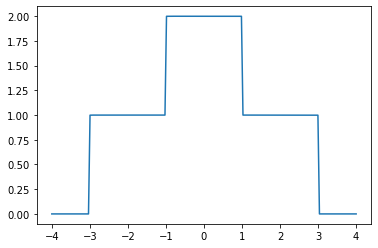

In [23]:
plt.plot(energies, np.real(land))
plt.show()

In [42]:
greenwood = gramag.kubo_greenwood(zs, op_sample, gramag.vx)

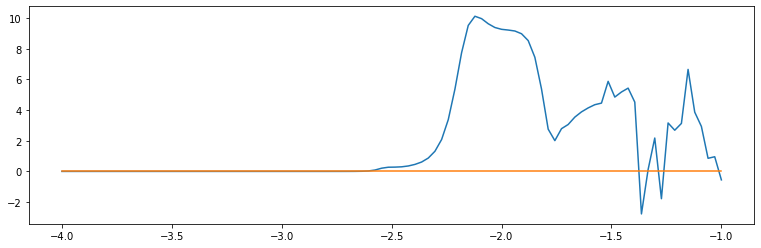

In [43]:
fig, axs = plt.subplots(1,1,figsize=(13,4))

axs.plot(energies, np.real(greenwood))
axs.plot(energies, np.imag(greenwood))
plt.show()

In [44]:
keld1, keld2, keld3 = gramag.keldysh(zs,n, op_local)
total = keld1 - keld2

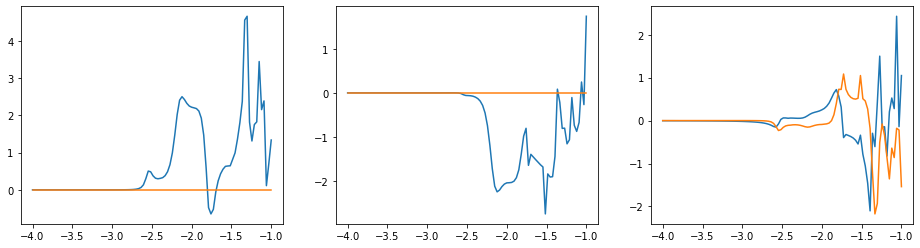

In [45]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
for i,k in enumerate([keld1, keld2, keld3]):
    axs[i].plot(energies, np.real(k))
    axs[i].plot(energies, np.imag(k))
plt.show()

## Bastin

eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
eta 0.00013717421124828533
Reached smallest eta


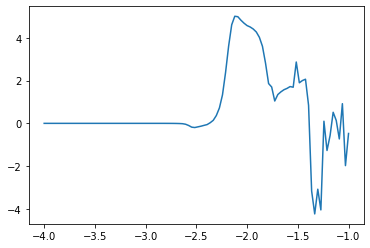

In [46]:
bas = bastin_integrator(gramag.kubo_bastin, op_sample)
bas.quiet = True
energies1 = np.linspace(-4,-1,100) # initial set of energy points for the adaptive integrator
de = 1e-5 # derivative to be used in Kubo-Bastin
bas.set_integrator(energies1, energies, de)
bas.integrator(0.03, 3e-4, 1e-1)
plt.plot(energies, np.imag(bas.bastin))
plt.show()

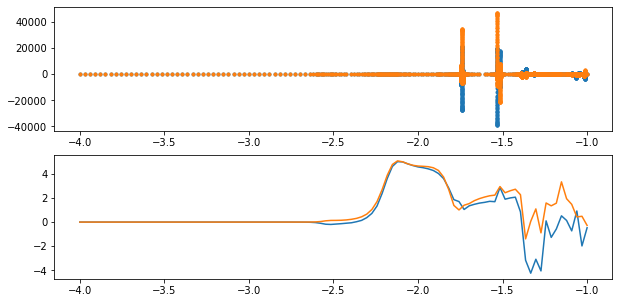

In [47]:
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].plot(bas.energies1, np.real(bas.bastingrand),'.')
axs[0].plot(bas.energies1, np.imag(bas.bastingrand),'.')
axs[1].plot(energies, np.imag(bas.bastin))
axs[1].plot(energies, np.real(greenwood)/2)
# plt.ylim([-3000, 15000])
# for i in range(2):
#     axs[i].set_xlim([-1.875204, -1.875202])

plt.show()

## Kubo Sea

eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
eta 0.00013717421124828533
Reached smallest eta


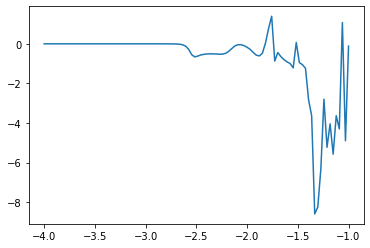

In [48]:
bas = bastin_integrator(gramag.kubo_sea, op_sample)
bas.quiet = True
energies1 = np.linspace(-4,-1,100) # initial set of energy points for the adaptive integrator
de = 1e-5 # derivative to be used in Kubo-Bastin
bas.set_integrator(energies1, energies, de)
bas.integrator(0.03, 3e-4, 1e-1)
plt.plot(energies, np.imag(bas.bastin))
plt.show()

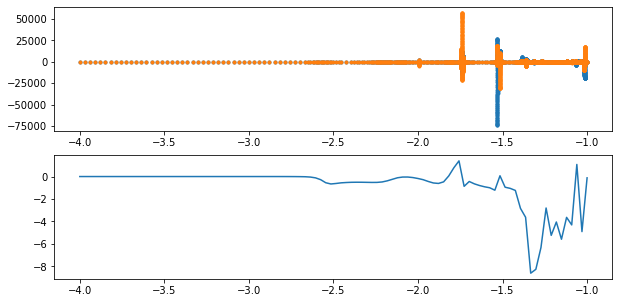

In [49]:
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].plot(bas.energies1, np.real(bas.bastingrand),'.')
axs[0].plot(bas.energies1, np.imag(bas.bastingrand),'.')
axs[1].plot(energies, np.imag(bas.bastin))

# plt.ylim([-3000, 15000])
# for i in range(2):
#     axs[i].set_xlim([-1.875204, -1.875202])

plt.show()

## Keldysh drop

In [50]:
# Energies
NE = 200
eta = 1e-7
energies = np.linspace(-4, -1, NE)
zs = energies + eta*1j

In [51]:
dV = 0.001
keld_drop = gramag.keldysh_drop(zs,n, op_local, dV)
keld_nodrop = gramag.keldysh_drop(zs,n, op_local, dV*0)

In [15]:
def dummy(z, op_local, par):
    drop, slic = par
    p1 = gramag.keldysh_drop(z, slic, op_local, drop)
    p2 = gramag.keldysh_drop(z, slic, op_local, 0.0)
    return (p1-p2)/drop

# self.fun(z, self.op, self.de)[0]

eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
eta 0.00013717421124828533
eta 4.5724737082761774e-05
eta 1.5241579027587257e-05
eta 5.0805263425290855e-06
Reached smallest eta


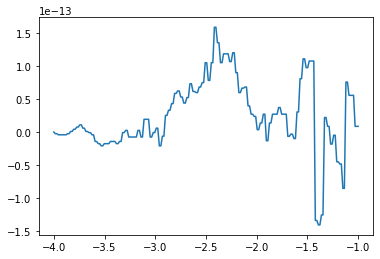

In [16]:
bas = bastin_integrator(dummy, op_local)
bas.quiet = True
energies1 = np.linspace(-4,-1,100) # initial set of energy points for the adaptive integrator
de = [dV, n] # derivative to be used in Kubo-Bastin
bas.set_integrator(energies1, energies, de)
bas.integrator(0.01, 1e-5, 1e-1)
plt.plot(energies, -np.imag(bas.bastin))
plt.show()

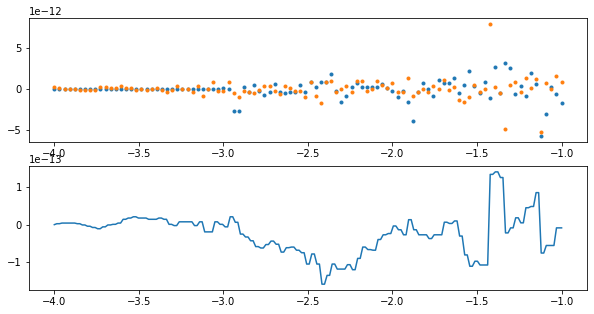

In [17]:
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].plot(bas.energies1, np.real(bas.bastingrand),'.')
axs[0].plot(bas.energies1, np.imag(bas.bastingrand),'.')
axs[1].plot(energies, np.imag(bas.bastin))
# axs[1].plot(energies, np.real(greenwood)/2)
# plt.ylim([-3000, 15000])
# for i in range(2):
#     axs[i].set_xlim([-1.875204, -1.875202])

plt.show()

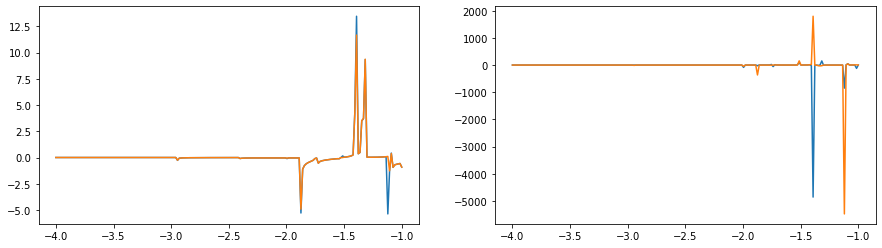

In [9]:
fig, axs = plt.subplots(1,2,figsize=(15,4))
axs[0].plot(energies, np.imag(keld_drop))
axs[0].plot(energies, np.imag(keld_nodrop))

axs[1].plot(energies, np.real(keld_drop-keld_nodrop)/dV)
axs[1].plot(energies, np.imag(keld_drop-keld_nodrop)/dV)

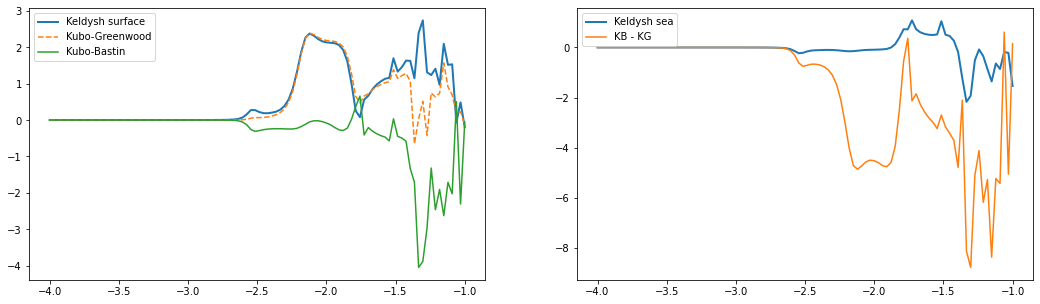

In [54]:
surface = np.real(keld1 - keld2)/2 #- np.imag(keld3)*0.5

factor = 2/(3.0*length-0.5)**1 

fig, axs = plt.subplots(1,2,figsize=(18,5))
axs[0].plot(energies, surface, linewidth=2, label="Keldysh surface")
axs[0].plot(energies, np.real(greenwood)*factor,'--', label="Kubo-Greenwood")
axs[0].plot(energies, np.imag(bas.bastin)*factor*2,'-', label="Kubo-Bastin")
axs[0].legend()

dif = np.imag(bas.bastin)*factor*2 - np.real(greenwood)*factor
axs[1].plot(energies, np.imag(keld3), linewidth=2, label="Keldysh sea")
axs[1].plot(energies, dif*2,'-', label="KB - KG")
# axs[1].set_xlim([-4,-2.5])
# axs[1].set_ylim([-1, 1])
axs[1].legend()


# axs[0].set_title("Local spin calculated with Keldysh and Kubo")
# axs[0].set_ylabel(r"<$s_x$>", fontsize=15)
# axs[0].set_xlabel("Fermi energy (t)", fontsize=15)
# axs.set_xlim([-3.5, -2.2])
# axs.set_ylim([-1, 1])
plt.show()

In [13]:
NE = 100
eta = 1e-7
energies = np.linspace(-4, -1, NE)
zs = energies + eta*1j
de = 1e-5
factor = 2/(3.0*length-0.5)**1 

In [16]:
# Choose the operator

# Operator in the slice and in the sample
fs = {}
keys = ["vx", "vy", "sx", "sy"]
ops = [gramag.vx[a:b,a:b], gramag.vy[a:b,a:b], sx*1.0, sy*1.0]

for key, op_local in zip(keys, ops):
    print(key)
    op_sample = np.zeros([C*S, C*S], dtype=complex)
    op_sample[a:b,a:b] = op_local

    greenwood = gramag.kubo_greenwood(zs, op_sample, gramag.vx)

    keld1, keld2, keld3 = gramag.keldysh(zs,n, op_local)
    kelsurf = keld1 - keld2

    energies1 = np.linspace(-4,-1,100) 
    bas = bastin_integrator(gramag.kubo_bastin, op_sample)
    bas.quiet = True
    bas.set_integrator(energies1, energies, de)
    bas.integrator(0.1, 1e-3, 1e-1)

    basea = bastin_integrator(gramag.kubo_sea, op_sample)
    basea.quiet = True
    basea.set_integrator(energies1, energies, de)
    basea.integrator(0.1, 1e-3, 1e-1)

    f1 = np.real(greenwood)*factor
    f2 = np.imag(bas.bastin)*factor*2
    f3 = np.imag(basea.bastin)*factor
    f4 = np.real(kelsurf)/2.0
    f5 = np.imag(keld3)

    fs[key] = [f1, f2, f3, f4, f5]

eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
Reached smallest eta
eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
Reached smallest eta
eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
Reached smallest eta
eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
Reached smallest eta
eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
Reached smallest eta
eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
Reached smallest eta
eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.000411

## represent

vx


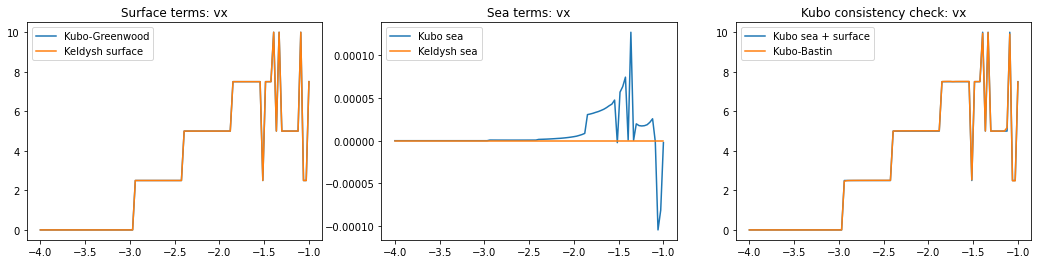

vy


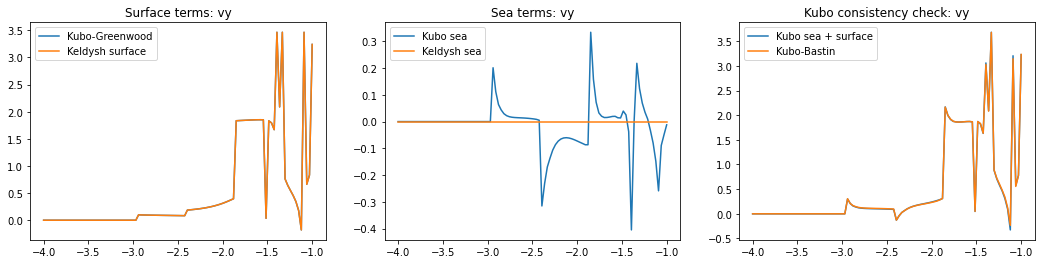

sx


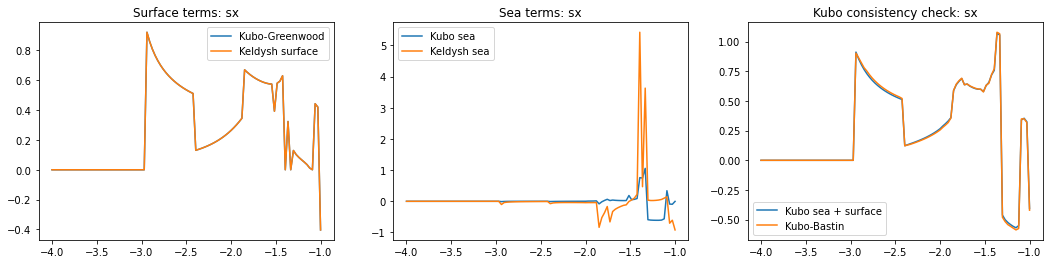

sy


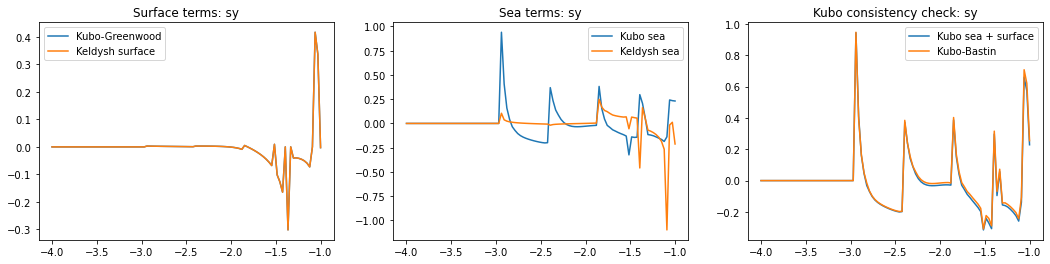

In [22]:
for f in fs:
    print(f)
    f1,f2,f3,f4,f5 = fs[f]
    fig, axs = plt.subplots(1,3,figsize=(18,4))
    axs[0].set_title("Surface terms: "+ f)
    axs[0].plot(energies, f1, label = "Kubo-Greenwood")
    axs[0].plot(energies, f4, label = "Keldysh surface")
    axs[0].legend()

    axs[1].set_title("Sea terms: "+ f)
    axs[1].plot(energies, f3, label = "Kubo sea")
    axs[1].plot(energies, f5, label = "Keldysh sea")
    axs[1].legend()

    axs[2].set_title("Kubo consistency check: "+ f)
    axs[2].plot(energies, f1 + f3, label = "Kubo sea + surface")
    axs[2].plot(energies, f2, label = "Kubo-Bastin")
    axs[2].legend()

    plt.show()
    # plt.plot(energies, np.imag(keld3))

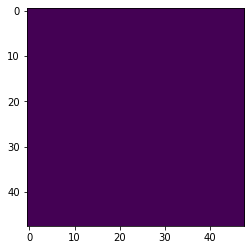

In [32]:
# Choose the operator



# Operator in the slice
op_local = np.zeros([C,C], dtype=complex)
# op_local = sx*1.0
op_local = sy*1.0
# op_local = gramag.vy[a:b,a:b]
# op_local = gramag.vx[a:b,a:b]


# Operator in the slice, but as part of the whole sample
op_sample = np.zeros([C*S, C*S], dtype=complex)
for n in range(length):
    a = C*n
    b = a+C
    op_sample[a:b,a:b] = op_local
    
plt.imshow(np.real(op_sample))
plt.show()

In [33]:
greenwood = gramag.kubo_greenwood(zs, op_sample, gramag.vx)

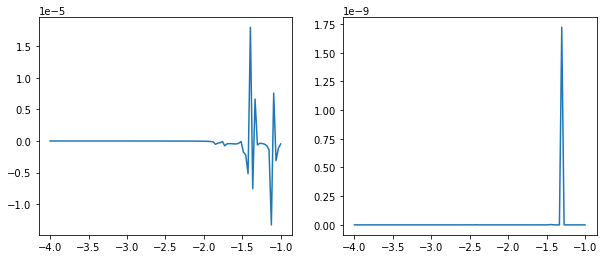

In [34]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(energies, np.real(greenwood))
axs[1].plot(energies, np.imag(greenwood))

In [35]:
keld1 = np.zeros(NE, dtype=complex)
keld2 = np.zeros(NE, dtype=complex)
keld3 = np.zeros(NE, dtype=complex)
for n in range(length):
    print(n)
    keld1n, keld2n, keld3n = gramag.keldysh(zs,n, op_local)
    keld1 += keld1n
    keld2 += keld2n
    keld3 += keld3n
    

0
1
2


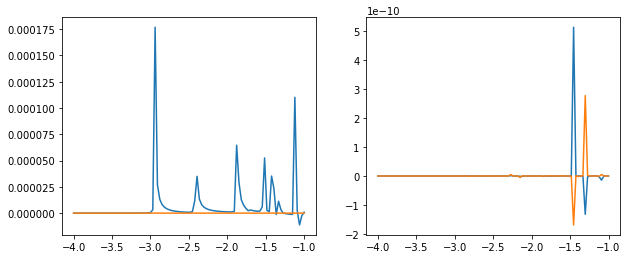

In [36]:
surf = keld1 - keld2
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(energies, np.real(surf))
axs[0].plot(energies, np.imag(surf))
axs[1].plot(energies, np.real(keld3))
axs[1].plot(energies, np.imag(keld3))


In [37]:
bas = bastin_integrator(gramag.kubo_bastin, op_sample)
bas.quiet = True
energies1 = np.linspace(-4,-1,100) # initial set of energy points for the adaptive integrator
de = 1e-5 # derivative to be used in Kubo-Bastin
bas.set_integrator(energies1, energies, de)
bas.integrator(0.03, 3e-4, 1e-1)
# plt.plot(energies, np.imag(bas.bastin))
# plt.show()

eta 0.03333333333333333
eta 0.011111111111111112
eta 0.003703703703703704
eta 0.0012345679012345679
eta 0.00041152263374485596
eta 0.00013717421124828533
Reached smallest eta


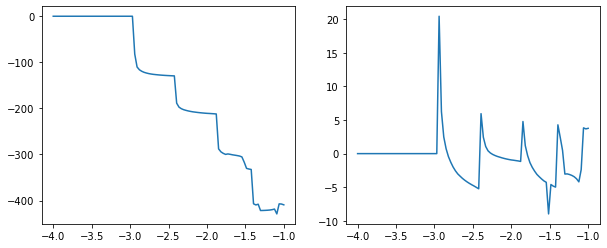

In [38]:

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(energies, np.real(bas.bastin))
axs[1].plot(energies, np.imag(bas.bastin))
plt.show()